In [2]:
from datasets import *
from train import *
from torchvision import datasets, transforms, models

load models

In [5]:
model = models.mobilenet_v3_large(weights='DEFAULT').to('cuda')
model64 = models.mobilenet_v3_large()
model64.load_state_dict(torch.load("best_modelsv3/best_batch_i1081020.pth")['model_state_dict'])
model64.to('cuda')
model.eval()
model64.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

load clean validation sets

In [7]:
clean_val_loader = load_imagenet(128,1234,False)
clean_val_loader64 = load_imagenet64(128,1234,False)

test clean validation sets

In [8]:
acc_clean = validate(model,clean_val_loader,'cuda')
acc64_clean = validate(model64,clean_val_loader64,'cuda')

100%|██████████| 391/391 [00:15<00:00, 25.82it/s]


load and validate corrupted sets

In [4]:
corruptions = ['gaussian_noise','impulse_noise','shot_noise','defocus_blur','glass_blur','motion_blur','zoom_blur','snow','frost','fog','brightness','contrast','elastic_transform','jpeg_compression','pixelate']
acc_corr = []
acc_corr64 = []

for corr in corruptions:
    corr_set = load_imagenetc_val(128,1234,corr,severity=1)
    corr_set64 = load_imagenetc64_val(128,1234,corr,severity=1)

    acc_corr.append(validate(model,corr_set,'cuda')[0])
    acc_corr64.append(validate(model64,corr_set64,'cuda')[0])
    

 37%|███▋      | 143/391 [00:11<00:20, 12.18it/s]


KeyboardInterrupt: 

save results to csv

In [ ]:
import pandas as pd
df = pd.DataFrame(columns=corruptions)
df.loc[0] = acc_corr
df.loc[1] = acc_corr64
df.insert(0, "Model", ['224x224', '64x64'])
df.insert(1,'Clean Acc.',[acc_clean,acc64_clean])
df.insert(2,'Avg Corr. Acc.',[sum(acc_corr)/len(acc_corr),sum(acc_corr64)/len(acc_corr64)])
df.to_csv("accuracy results1.csv")

clean confidence scores

In [ ]:
def get_conf_cal(data_loader, model):
    confidences = torch.zeros(len(data_loader.dataset))
    accuracies = torch.zeros(len(data_loader.dataset))

    # load the entire validation set
    idx = 0
    with torch.no_grad():
        for (img_batch, label_batch) in tqdm(data_loader):
            img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')

            start = idx*data_loader.batch_size
            end = start + data_loader.batch_size
            if end > len(data_loader.dataset):
                end = len(data_loader.dataset)

            # get the model's softmax output and class predictions, then get a mask of correct predictions
            conf, pred = torch.max(F.softmax(model(img_batch), dim=1), 1)
            acc = pred.eq(label_batch)
            conf,pred,acc = conf.to('cpu'),pred.to('cpu'),acc.to('cpu')

            confidences[start:end] = conf
            accuracies[start:end] = acc
            idx +=  1

    # initialize the calibration bins
    n_bins = 10
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    accs = [0.0]*n_bins
    avg_confs = [0.0]*n_bins

    i = 0
    # iterate over bins
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # mask to determine which confidence scores go in this bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())

        # from the mask determine what percent of the confidence scores are in this bin
        prop_in_bin = in_bin.float().mean()

        # if the bin is not empty
        if prop_in_bin.item() > 0:
            # calculate accuracy of the bin using the mask of correct predictions
            accuracy_in_bin = accuracies[in_bin].float().mean()

            # get the average confidence score of items in this bin
            avg_confidence_in_bin = confidences[in_bin].mean()
            accs[i] = accuracy_in_bin
            avg_confs[i] = avg_confidence_in_bin.detach()
        i+=1
    
    # return the accuracy of all bins and the average confidence score of the bins
    return accs, avg_confs

accs_cal, confs_cal = get_conf_cal(clean_val_loader,model)
accs64_cal, confs64_cal = get_conf_cal(clean_val_loader64,model64)

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(14, 6), dpi=100)
bars = ["0-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"]
xpos = [0,5,10,15,20,25,30,35,40,45]
plt.bar(xpos,confs_cal,label="conf",width=2)
plt.xticks(xpos, bars)
plt.bar(xpos,accs_cal,label="acc",width=2,alpha=0.5)
plt.xticks(xpos, bars)
plt.legend()
plt.title('Mobilenet V3 Large Confidence Scores (Input 224x224)')
plt.xlabel("Confidence Intervals")
plt.ylabel("Avg. Confidence and Accuracy Value per Bin")
plt.grid()

In [ ]:
figure(figsize=(14, 6), dpi=100)
bars = ["0-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"]
xpos = [0,5,10,15,20,25,30,35,40,45]
plt.bar(xpos,confs64_cal,label="conf",width=2)
plt.xticks(xpos, bars)
plt.bar(xpos,accs64_cal,label="acc",width=2,alpha=0.5)
plt.xticks(xpos, bars)
plt.legend()
plt.title('Mobilenet V3 Large Confidence Scores (Input 64x64)')
plt.xlabel("Confidence Intervals")
plt.ylabel("Avg. Confidence and Accuracy Value per Bin")
plt.grid()

corrupted confidence scores

In [9]:
corruptions = ['gaussian_noise','impulse_noise','shot_noise','defocus_blur','glass_blur','motion_blur','zoom_blur','snow','frost','fog','brightness','contrast','elastic_transform','jpeg_compression','pixelate']

def get_conf_cal_corr(data_loaders, model):
    confidences = torch.zeros(len(data_loaders[0].dataset)*len(data_loaders))
    accuracies = torch.zeros(len(data_loaders[0].dataset)*len(data_loaders))
    print(len(confidences))

    # load the entire validation set
    with torch.no_grad():
        for dl_idx, data_loader in enumerate(data_loaders):
            print(corruptions[dl_idx])
            idx = 0
            for (img_batch, label_batch) in tqdm(data_loader):
                img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')

                start = dl_idx*len(data_loader.dataset) + idx*data_loader.batch_size
                end = start + len(label_batch)

                # get the model's softmax output and class predictions, then get a mask of correct predictions
                conf, pred = torch.max(F.softmax(model(img_batch), dim=1), 1)
                acc = pred.eq(label_batch)
                conf,pred,acc = conf.to('cpu'),pred.to('cpu'),acc.to('cpu')

                confidences[start:end] = conf
                accuracies[start:end] = acc

                idx +=  1

    # initialize the calibration bins
    n_bins = 10
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    accs = [0.0]*n_bins
    avg_confs = [0.0]*n_bins

    i = 0
    # iterate over bins
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # mask to determine which confidence scores go in this bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        print(in_bin,"/",len(in_bin))

        # from the mask determine what percent of the confidence scores are in this bin
        prop_in_bin = in_bin.float().mean()

        # if the bin is not empty
        if prop_in_bin.item() > 0:
            # calculate accuracy of the bin using the mask of correct predictions
            accuracy_in_bin = accuracies[in_bin].float().mean()

            # get the average confidence score of items in this bin
            avg_confidence_in_bin = confidences[in_bin].mean()
            accs[i] = accuracy_in_bin
            avg_confs[i] = avg_confidence_in_bin.detach()
        i+=1
    
    # return the accuracy of all bins and the average confidence score of the bins
    return accs, avg_confs

corrs = []
corrs64 = []
for corr in corruptions:
    corrs.append(load_imagenetc_val(128,1234,corr))
    corrs64.append(load_imagenetc64_val(128,1234,corr))

accs_cal, confs_cal = get_conf_cal_corr(corrs,model)
accs64_cal, confs64_cal = get_conf_cal_corr(corrs64,model64)

750000
gaussian_noise


100%|██████████| 391/391 [00:26<00:00, 14.77it/s]


impulse_noise


100%|██████████| 391/391 [00:23<00:00, 16.34it/s]


shot_noise


100%|██████████| 391/391 [00:26<00:00, 15.02it/s]


defocus_blur


100%|██████████| 391/391 [00:27<00:00, 14.32it/s]


glass_blur


100%|██████████| 391/391 [00:27<00:00, 14.41it/s]


motion_blur


100%|██████████| 391/391 [00:27<00:00, 14.07it/s]


zoom_blur


100%|██████████| 391/391 [00:23<00:00, 16.93it/s]


snow


100%|██████████| 391/391 [00:26<00:00, 14.79it/s]


frost


100%|██████████| 391/391 [00:26<00:00, 14.70it/s]


fog


100%|██████████| 391/391 [00:26<00:00, 14.76it/s]


brightness


100%|██████████| 391/391 [00:27<00:00, 14.39it/s]


contrast


100%|██████████| 391/391 [00:26<00:00, 14.78it/s]


elastic_transform


100%|██████████| 391/391 [00:27<00:00, 14.22it/s]


jpeg_compression


100%|██████████| 391/391 [00:25<00:00, 15.17it/s]


pixelate


100%|██████████| 391/391 [00:27<00:00, 14.08it/s]


tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False,  True, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False,  True, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ...,  True, False, False]) / 750000
tensor([False, False,  True,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([ True, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False,  True]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
750000
gaussian_noise


100%|██████████| 391/391 [00:05<00:00, 77.77it/s]


impulse_noise


100%|██████████| 391/391 [00:05<00:00, 77.47it/s]


shot_noise


100%|██████████| 391/391 [00:05<00:00, 76.33it/s]


defocus_blur


100%|██████████| 391/391 [00:05<00:00, 77.56it/s]


glass_blur


100%|██████████| 391/391 [00:05<00:00, 75.77it/s]


motion_blur


100%|██████████| 391/391 [00:05<00:00, 76.55it/s]


zoom_blur


100%|██████████| 391/391 [00:05<00:00, 76.86it/s]


snow


100%|██████████| 391/391 [00:05<00:00, 75.83it/s]


frost


100%|██████████| 391/391 [00:05<00:00, 76.27it/s]


fog


100%|██████████| 391/391 [00:05<00:00, 76.84it/s]


brightness


100%|██████████| 391/391 [00:05<00:00, 76.63it/s]


contrast


100%|██████████| 391/391 [00:05<00:00, 76.25it/s]


elastic_transform


100%|██████████| 391/391 [00:05<00:00, 75.44it/s]


jpeg_compression


100%|██████████| 391/391 [00:05<00:00, 76.77it/s]


pixelate


100%|██████████| 391/391 [00:05<00:00, 76.58it/s]

tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False,  True,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False,  True, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ...,  True, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([ True, False, False,  ..., False,  True, False]) / 750000
tensor([False, False, False,  ..., False, False,  True]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000


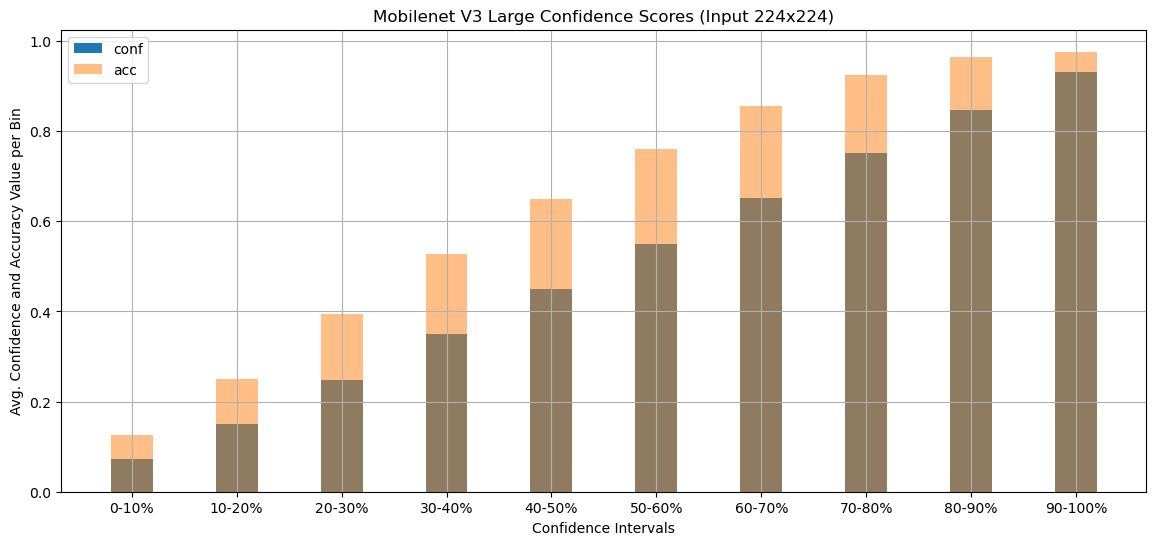

In [10]:
from matplotlib.pyplot import figure
figure(figsize=(14, 6), dpi=100)
bars = ["0-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"]
xpos = [0,5,10,15,20,25,30,35,40,45]
plt.bar(xpos,confs_cal,label="conf",width=2)
plt.xticks(xpos, bars)
plt.bar(xpos,accs_cal,label="acc",width=2,alpha=0.5)
plt.xticks(xpos, bars)
plt.legend()
plt.title('Mobilenet V3 Large Confidence Scores (Input 224x224)')
plt.xlabel("Confidence Intervals")
plt.ylabel("Avg. Confidence and Accuracy Value per Bin")
plt.grid()

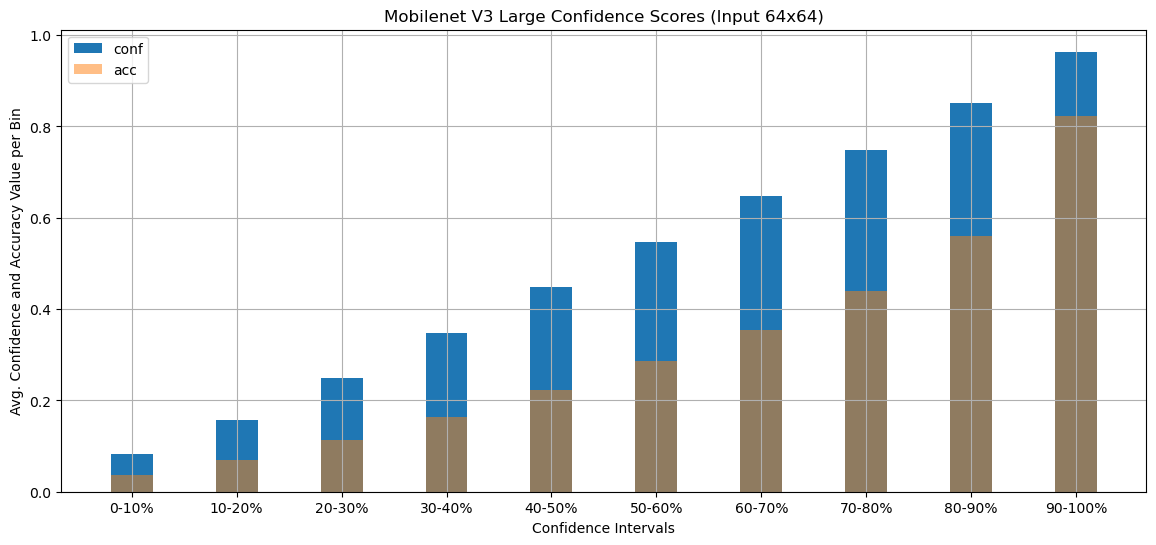

In [11]:
figure(figsize=(14, 6), dpi=100)
bars = ["0-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"]
xpos = [0,5,10,15,20,25,30,35,40,45]
plt.bar(xpos,confs64_cal,label="conf",width=2)
plt.xticks(xpos, bars)
plt.bar(xpos,accs64_cal,label="acc",width=2,alpha=0.5)
plt.xticks(xpos, bars)
plt.legend()
plt.title('Mobilenet V3 Large Confidence Scores (Input 64x64)')
plt.xlabel("Confidence Intervals")
plt.ylabel("Avg. Confidence and Accuracy Value per Bin")
plt.grid()

online accuracies

put all data loaders in same order

In [21]:
from torch.utils.data import Subset

from torch.utils.data.sampler import Sampler

class CustomOrder(Sampler):
    def __init__(self, dataset):
        self.order = torch.randperm(len(dataset))
        
    def __iter__(self):
        return iter(self.order)
    
    def __len__(self):
        return len(self.order)

get all the confidences and results

In [ ]:
# confidence is highest softmax output
# result is whether a prediction was correct 
clean_confidences = torch.zeros(len(clean_val_loader.dataset))
clean_results = torch.zeros(len(clean_val_loader.dataset))
clean_confidences64 = torch.zeros(len(clean_val_loader.dataset))
clean_results64 = torch.zeros(len(clean_val_loader.dataset))

corr_confidences = torch.zeros(len(clean_val_loader.dataset)*len(corrs))
corr_results = torch.zeros(len(clean_val_loader.dataset)*len(corrs))
corr_confidences64 = torch.zeros(len(clean_val_loader.dataset)*len(corrs))
corr_results64 = torch.zeros(len(clean_val_loader.dataset)*len(corrs))

# average over 3 random orderings
for i in range(3):
    print("================ ordering:",i, " ================")
    # put all datasets in fixed order
    fixed_order = CustomOrder(clean_val_loader.dataset)
    rand_corr_order = torch.randperm(15)
    clean_val_loader = DataLoader(clean_val_loader.dataset,batch_size=128,sampler=fixed_order)
    clean_val_loader64 = DataLoader(clean_val_loader64.dataset,batch_size=128,sampler=fixed_order)

    for i,corr in enumerate(corruptions):
        corrs[i] = DataLoader(corrs[i].dataset,batch_size=128,sampler=fixed_order)
        corrs64[i] = DataLoader(corrs64[i].dataset,batch_size=128,sampler=fixed_order)

    with torch.no_grad():
        # first get the clean results

        for dl_idx, data_loader in enumerate(corrs):
            print(corruptions[dl_idx])
            idx = 0
            for (img_batch, label_batch) in tqdm(data_loader):
                img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')

                start = dl_idx*len(data_loader.dataset) + idx*data_loader.batch_size
                end = start + len(label_batch)

                # get the model's softmax output and class predictions, then get a mask of correct predictions
                conf, pred = torch.max(F.softmax(model(img_batch), dim=1), 1)
                acc = pred.eq(label_batch)
                conf,pred,acc = conf.to('cpu'),pred.to('cpu'),acc.to('cpu')

                confidences[start:end] = conf
                accuracies[start:end] = acc

                idx +=  1

clean baseline

In [17]:
# clean baseline
clean_online_acc = []
clean_online_acc64 = []
clean_naive_online_acc = []
clean_oracle_acc = []
idxs = []

num_imgs = 0

clean_num_correct = 0
clean_num_correct64 = 0
clean_num_naive_correct = 0
clean_num_oracle_correct = 0

clean_num_wrong_decisions = 0
clean_num_choose_itself = 0
clean_num_choose_big = 0

clean_overconfident_locations = []
clean_overconfident_imgs = []
clean_underconfident_locations = []
clean_underconfident_imgs = []

for sample_idx in tqdm(rand_order):
    num_imgs += 1
    # get the image at the specified index
    img,target = clean_val_loader.dataset[sample_idx]
    img64,target64 = clean_val_loader64.dataset[sample_idx]
    img,target = img.to('cuda'),torch.tensor(target).to('cuda')
    img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')
    # get the prediction
    out = model(img.unsqueeze(0))
    out64 = model64(img64.unsqueeze(0))
    pred = out.argmax(dim=1).item()
    pred64 = out64.argmax(dim=1).item()
    res = (pred == target.item())
    res64 = (pred64 == target64.item())
    clean_num_correct += res
    clean_num_correct64 += res64
    clean_online_acc.append(clean_num_correct/num_imgs)
    clean_online_acc64.append(clean_num_correct64/num_imgs)

    # oracle, if small is right choose small, else choose big
    if res64:
        clean_num_oracle_correct += res64
    else:
        clean_num_oracle_correct += res
    clean_oracle_acc.append(clean_num_oracle_correct/num_imgs)    


    # naive strategy, if less than 50% confident, use big model
    if torch.nn.Softmax()(out64).max().item() < 0.50:
        clean_num_naive_correct += res
        clean_num_choose_big += 1
        # if was underconfident
        if res64:
            clean_num_wrong_decisions += 1
            clean_underconfident_imgs.append(sample_idx)
            clean_underconfident_locations.append(num_imgs)
    else:
        clean_num_naive_correct += res64
        clean_num_choose_itself += 1
        # if was overconfident
        if not res64 and res:
            clean_num_wrong_decisions += 1
            clean_overconfident_imgs.append(sample_idx)
            clean_overconfident_locations.append(num_imgs)
    clean_naive_online_acc.append(clean_num_naive_correct/num_imgs)

    idxs.append(num_imgs)

  0%|          | 0/50000 [00:00<?, ?it/s]/tmp/ipykernel_3835347/1797129348.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if torch.nn.Softmax()(out64).max().item() < 0.50:
100%|██████████| 50000/50000 [12:56<00:00, 64.40it/s]


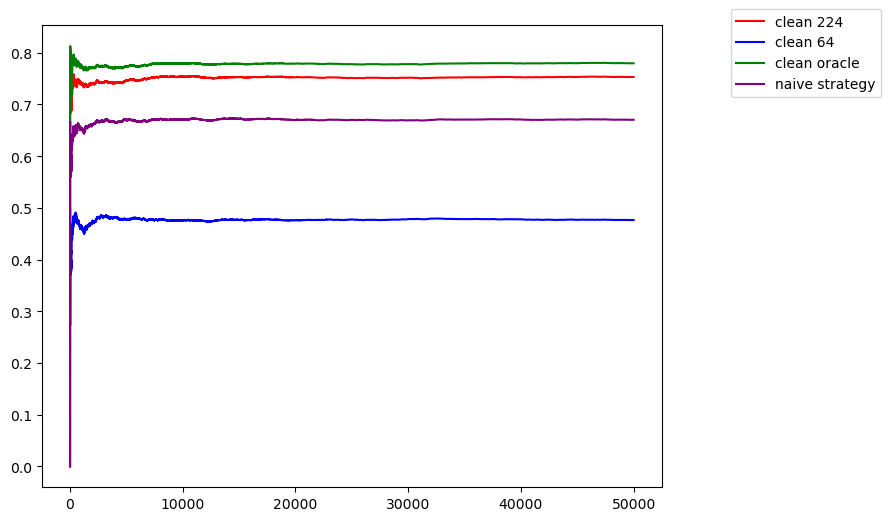

In [19]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,clean_online_acc,label='clean 224',color='red')
ax1.plot(idxs,clean_online_acc64,label='clean 64',color='blue')
ax1.plot(idxs,clean_oracle_acc,label='clean oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,clean_naive_online_acc,label='naive strategy',color='purple')

# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
# ax1.set_ylabel("Online Accuracy")
# ax2.set_ylabel("# overconfident images")
# ax1.set_xlabel("Image Index")

corrupt baseline

In [14]:
# naive strategy
corr_naive_online_acc = []
corr_online_acc = []
corr_online_acc64 = []
idxs = []
num_imgs = 0
corr_num_correct = 0
corr_num_correct64 = 0
corr_num_naive_correct = 0
rand_corr_order = torch.randperm(15)
corr_idx = 0
corr_img_count = 0
corr_num_wrong_decisions = 0
corr_num_choose_itself = 0
corr_num_choose_big = 0
corr_overconfident_locations = []
corr_overconfident_imgs = []
corr_underconfident_locations = []
corr_underconfident_imgs = []
transition_points = [500]
for sample_idx in tqdm(rand_order):
    # corruptions start after the first 500 images
    if num_imgs-1 > 499:
        # each corruption lasts 3300 images
        if corr_img_count == 3300:
            corr_idx += 1
            corr_img_count = 0
            transition_points.append(num_imgs)
        # get the image at the specified index
        img,target = corrs[rand_corr_order[corr_idx]].dataset[sample_idx]
        img64,target64 = corrs64[rand_corr_order[corr_idx]].dataset[sample_idx]
        img,target = img.to('cuda'),torch.tensor(target).to('cuda')
        img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')
        corr_img_count += 1
    else:
        img,target = clean_val_loader.dataset[sample_idx]
        img64,target64 = clean_val_loader64.dataset[sample_idx]
        img,target = img.to('cuda'),torch.tensor(target).to('cuda')
        img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')

    num_imgs += 1
    
    # get the prediction
    out = model(img.unsqueeze(0))
    out64 = model64(img64.unsqueeze(0))
    pred = out.argmax(dim=1).item()
    pred64 = out64.argmax(dim=1).item()
    res = (pred == target.item())
    res64 = (pred64 == target64.item())
    corr_num_correct += res
    corr_num_correct64 += res64
    corr_online_acc.append(corr_num_correct/num_imgs)
    corr_online_acc64.append(corr_num_correct64/num_imgs)

    # naive strategy, if less than 50% confident, use big model
    if torch.nn.Softmax()(out64).max().item() < 0.50:
        corr_num_naive_correct += res
        corr_num_choose_big += 1
        # if was underconfident
        if res64:
            corr_num_wrong_decisions += 1
            corr_underconfident_imgs.append(sample_idx)
            corr_underconfident_locations.append(num_imgs)
    else:
        corr_num_naive_correct += res64
        corr_num_choose_itself += 1
        # if was overconfident
        if not res64 and res:
            corr_num_wrong_decisions += 1
            corr_overconfident_imgs.append(sample_idx)
            corr_overconfident_locations.append(num_imgs)
    corr_naive_online_acc.append(corr_num_naive_correct/num_imgs)
    idxs.append(num_imgs)

  0%|          | 0/50000 [00:00<?, ?it/s]/tmp/ipykernel_3835347/1528852718.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if torch.nn.Softmax()(out64).max().item() < 0.50:
100%|██████████| 50000/50000 [10:17<00:00, 80.91it/s]
